In [1]:
# just trainig for all the jets in the pt range (500, 2000) GeV
# Grid Search for best parameters 
import random
from re import X

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_curve, auc


import uproot 
import awkward as ak

file = "/global/cfs/projectdirs/atlas/hrzhao/qgcal/BDT_EB3/pkls/small_sample_periodA.pkl"

small_sample = pd.read_pickle(file)

In [3]:
small_sample_array = small_sample.to_numpy()

In [4]:
small_sample_array.shape

(200000, 10)

In [5]:
X = small_sample_array[:, :-1]
y = small_sample_array[:, -1]

In [9]:
X[:, 7]

array([0.3904843 , 0.15126295, 0.09193534, ..., 1.61380994, 0.61529815,
       0.00936656])

In [10]:
X[:, 8]

array([4.06940610e-07, 1.10664131e-06, 8.05575838e-07, ...,
       5.47546735e-07, 4.40407886e-07, 4.24392991e-07])

In [8]:
y

array([0., 0., 0., ..., 1., 1., 1.])

In [11]:
def draw_pt_spectrum(pt_array, bins, user_weights = None, title = ' ', use_log = True, save = False):
    fig, ax = plt.subplots()
    if user_weights is None:
        ax.hist(pt_array, bins)
    else:
        ax.hist(pt_array, bins, weights = user_weights)
    ax.set_title(title + '$p_{T}$ Spectrum')
    ax.set_xlabel('Jet $p_{\mathrm{T}}$ [GeV]')
    ax.set_ylabel('Number of Jets')
    if use_log:
        ax.set_yscale('log')
    if save:
        file_title = title.replace(' ','_') + 'pt_distribution'
        if use_log:
            file_title = file_title + 'log'
        fig.savefig(file_title)
    fig.show()

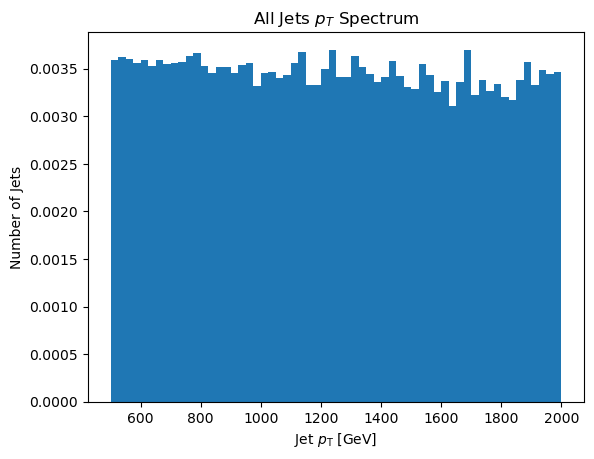

In [14]:
custom_bins = np.linspace(500, 2000, 61)
draw_pt_spectrum(X[:,0], custom_bins, use_log=False,
                 title = 'All Jets ', user_weights = X[:,8], save = False)

In [15]:
print(f"X Shape: {X.shape}")
print(f"y Shape: {y.shape}")

from sklearn.model_selection import train_test_split

X_dev,X_eval, y_dev,y_eval = train_test_split(X, y, test_size=0.1, random_state=456)
X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.1/0.9, random_state=789)

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score

dt = DecisionTreeClassifier(max_depth=3,
                            min_samples_leaf=0.001,
                            max_features="log2")
bdt = AdaBoostClassifier(dt,
                        algorithm="SAMME",
                        n_estimators=800,
                        learning_rate=0.001)

scores = cross_val_score(bdt,
                        X_dev[:,0:5], y_dev,
                        scoring="roc_auc",
                        n_jobs=6,
                        cv=3)

print("Accuracy: %0.5f (+/- %0.5f)"%(scores.mean(), scores.std()))

from sklearn import model_selection 
param_grid = {"base_estimator__max_depth": [5, 7, 9],
              "n_estimators": [500, 750, 1000],
              'learning_rate': [0.1, 0.5, 1.]}


clf = model_selection.GridSearchCV(bdt,
                               param_grid,
                               cv=3,
                               scoring='roc_auc',
                               n_jobs=8,
                               verbose=3)
_ = clf.fit(X_dev[:,:5],y_dev, sample_weight = X_dev[:,8] )

print("Best parameter set found on development set:\n")
print(clf.best_estimator_)
print("Grid scores on a subset of the development set:\n")

import pickle
with open('cv_results_flat_pt.pkl', 'wb') as f:
    pickle.dump(clf.cv_results_, f)


X Shape: (200000, 9)
y Shape: (200000,)
Accuracy: 0.81446 (+/- 0.00124)
Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 2/3] END base_estimator__max_depth=5, learning_rate=0.1, n_estimators=500;, score=0.843 total time= 1.3min
[CV 3/3] END base_estimator__max_depth=5, learning_rate=0.1, n_estimators=500;, score=0.843 total time= 1.3min
[CV 1/3] END base_estimator__max_depth=5, learning_rate=0.1, n_estimators=500;, score=0.841 total time= 1.4min
[CV 3/3] END base_estimator__max_depth=5, learning_rate=0.1, n_estimators=750;, score=0.843 total time= 2.0min
[CV 2/3] END base_estimator__max_depth=5, learning_rate=0.1, n_estimators=750;, score=0.844 total time= 2.1min
[CV 1/3] END base_estimator__max_depth=5, learning_rate=0.1, n_estimators=750;, score=0.842 total time= 2.1min
